# Imports

In [146]:
import re
import pandas as pd
import numpy as np
import scipy
from scipy.stats import linregress
from scipy import stats
import scipy.stats as stats
from scipy.stats import pearsonr, linregress
import statsmodels.api as sm
import pingouin as pg
from statsmodels.stats.multitest import multipletests
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import warnings
import matplotlib.cbook
import matplotlib.dates as mdates
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
import seaborn as sns
sns.set_theme(style="white")
# import calplot
# import july

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, adjusted_rand_score,r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import RepeatedKFold, cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from xgboost import XGBRFClassifier

In [147]:
project_path = Path.cwd()
print(f'project_path: {project_path}')
print('')
project_data_sources_path = Path.cwd() / 'data' / 'sources'
print(f'project_data_sources_path: {project_data_sources_path}')
print('')
project_data_exports_path = Path.cwd() / 'data' / 'exports'
print(f'project_data_exports_path: {project_data_exports_path}')

project_path: /Users/chrisizenour/Library/CloudStorage/Dropbox/python/projects/katie_dissertation

project_data_sources_path: /Users/chrisizenour/Library/CloudStorage/Dropbox/python/projects/katie_dissertation/data/sources

project_data_exports_path: /Users/chrisizenour/Library/CloudStorage/Dropbox/python/projects/katie_dissertation/data/exports


# User Defined Functions

## Dataset Import and Wrangling

In [149]:
def load_ectos_dataset():
    df = pd.read_excel(
        project_data_sources_path / 'Ectos and molecular to Chris.xlsx',
        sheet_name='Ectos',
        # header=1
    )
    # df = df.iloc[:-2]
    print(f'Shape of dataframe: {df.shape[0]} rows, {df.shape[1]} columns')
    return df

In [150]:
def load_snap_dataset():
    df = pd.read_excel(
        project_data_sources_path / 'Ectos and molecular to Chris.xlsx',
        sheet_name='SNAP',
        # header=1
    )
    # df = df.iloc[:-2]
    print(f'Shape of dataframe: {df.shape[0]} rows, {df.shape[1]} columns')
    return df

In [151]:
def load_pcr_dataset():
    df = pd.read_excel(
        project_data_sources_path / 'Ectos and molecular to Chris.xlsx',
        sheet_name='PCR',
        # header=1
    )
    # df = df.iloc[:-2]
    print(f'Shape of dataframe: {df.shape[0]} rows, {df.shape[1]} columns')
    return df

In [152]:
def load_data_line_list_dataset():
    df = pd.read_excel(
        project_data_sources_path / 'Ectos and molecular to Chris.xlsx',
        sheet_name='Data line list',
        # header=1
    )
    # df = df.iloc[:-2]
    print(f'Shape of dataframe: {df.shape[0]} rows, {df.shape[1]} columns')
    return df

In [153]:
def load_combined_dataset():
    df = pd.read_excel(
        project_data_sources_path / 'Ectos and molecular to Chris.xlsx',
        sheet_name='Sheet1',
        usecols='A:I'
        # header=1
    )
    # df = df.iloc[:-2]
    print(f'Shape of dataframe: {df.shape[0]} rows, {df.shape[1]} columns')
    return df

In [154]:
def clean_df_columns(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('/', '_')
    # df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')
    # df['date_str'] = df['game_date'].dt.strftime('%Y-%m-%d') 
    return df

## Statistical Tests

In [155]:
def category_contingency_table(category1, category2):
    '''Create contingency table for categories to perform chi2 contingency test'''
    df = pd.crosstab(category1, category2)
    return df

In [156]:
def chi2_contingency_func2(contingency_table, category1_name, category2_name, kpi, kpi_type):
    chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

    expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)

    # calculate cramer's V for effect size
    n= contingency_table.sum().sum()
    cramer_v = np.sqrt(chi2_stat / (n * min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1)))

    if cramer_v < 0.1:
        cramer_v_interp = 'small_effect_size'
    elif cramer_v < 0.3:
        cramer_v_interp = 'medium_effect_size'
    else:
        cramer_v_interp = 'large_effect_size'

    # interpret results
    significant = p_val < 0.05
    result = 'statistically significant association' if significant else 'no statistically significant association'

    # prepare output
    results_df = pd.DataFrame({
        'statistic': ['chi2', 'p_value', 'degrees_of_freedom', "cramer's_v", "cramer's_v_interpretation", 'result'],
        'value': [chi2_stat, p_val, dof, cramer_v, cramer_v_interp, result]
    })

    expected_explanation = [f'{category1_name}={index}, {category2_name}={col}: Actual={contingency_table.at[index, col]}, Expected={expected_df.at[index,col]:.2f}'
                            for index in expected_df.index for col in expected_df.columns]
    expected_explanation_df = pd.DataFrame({'expected_frequencies_detail': expected_explanation})

    output_df = pd.concat([results_df, expected_explanation_df], ignore_index=True)
    return output_df

# Import Data

In [157]:
ectos_df = load_ectos_dataset()
ectos_df = clean_df_columns(ectos_df)
ectos_df.to_csv(f'{project_data_exports_path}/ectos_df.csv')
ectos_df

Shape of dataframe: 140 rows, 7 columns


,animal_sample_id,tube_id,host_species,sampling_location,ectoparasite_genus,ectoparasite_species,stage_sex
0,1,1.1,Dog,Privately Owned,Rhipicephalus,sanguineus,female
1,1,1.2,Dog,Privately Owned,Rhipicephalus,sanguineus,female
2,1,1.3,Dog,Privately Owned,Rhipicephalus,sanguineus,female
3,1,1.4,Dog,Privately Owned,Rhipicephalus,sanguineus,female
4,21,21.0,Cow,Privately Owned,Rhipicephalus,sanguineus,female
...,...,...,...,...,...,...,...
135,237,237.4,Cow,Privately Owned,Rhipicephalus,annulatus,female
136,237,237.5,Cow,Privately Owned,Rhipicephalus,annulatus,"male, female"
137,238,238.0,Dog,Privately Owned,Rhipicephalus,sanguineus,female
138,239,239.0,Dog,Privately Owned,Rhipicephalus,sanguineus,female


In [158]:
snap_df = load_snap_dataset()
snap_df = clean_df_columns(snap_df)
snap_df.to_csv(f'{project_data_exports_path}/snap_df.csv')
snap_df

Shape of dataframe: 116 rows, 8 columns


,animal_sample_id,host_species,sampling_location,test_type,result,unnamed:_5,unnamed:_6,unnamed:_7
0,70,Dog,Privately Owned,SNAP,Anaplasma sp. only,NaN,NaN,Privately Owned
1,71,Dog,Privately Owned,SNAP,All negative,NaN,NaN,University Research Animal
2,72,Dog,Privately Owned,SNAP,All negative,NaN,NaN,Animal Rescue
3,73,Dog,Privately Owned,SNAP,All negative,NaN,NaN,NaN
4,74,Dog,Privately Owned,SNAP,All negative,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
111,246,Dog,Privately Owned,SNAP,All negative,NaN,NaN,NaN
112,249,Dog,Privately Owned,SNAP,All negative,NaN,NaN,NaN
113,250,Dog,Privately Owned,SNAP,All negative,NaN,NaN,NaN
114,251,Dog,Privately Owned,SNAP,All negative,NaN,NaN,NaN


In [159]:
pcr_df = load_pcr_dataset()
pcr_df = clean_df_columns(pcr_df)
pcr_df.to_csv(f'{project_data_exports_path}/pcr_df.csv')
pcr_df

Shape of dataframe: 248 rows, 11 columns


,animal_sample_id,host_species,sampling_location,test_type,anaplasma,babesia,bartonella,borrelia,dirofilaria,ehrlichia,rickettsia
0,2,Goat,University Research Animal,PCR,0.0,NaN,0.0,NaN,0.0,NaN,NaN
1,3,Goat,University Research Animal,PCR,0.0,NaN,0.0,NaN,0.0,NaN,NaN
2,4,Goat,University Research Animal,PCR,0.0,NaN,0.0,NaN,0.0,NaN,NaN
3,5,Goat,University Research Animal,PCR,0.0,NaN,0.0,NaN,0.0,NaN,NaN
4,6,Goat,University Research Animal,PCR,0.0,NaN,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
243,6,Cow,Privately Owned,PCR not performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,68,Cow,Privately Owned,PCR not performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,69,Dog,Privately Owned,PCR not performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,81,Dog,Privately Owned,PCR not performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
data_line_df = load_data_line_list_dataset()
data_line_df = clean_df_columns(data_line_df)
data_line_df.to_csv(f'{project_data_exports_path}/data_line_df.csv')
data_line_df

Shape of dataframe: 252 rows, 3 columns


,animal_sample_id,host_species,sampling_location
0,1,Dog,Privately owned
1,2,Goat,University Research Animal
2,3,Goat,University Research Animal
3,4,Goat,University Research Animal
4,5,Goat,University Research Animal
...,...,...,...
247,248,Horse,Privately owned
248,249,Dog,Privately owned
249,250,Dog,Privately owned
250,251,Dog,Privately owned


In [161]:
df = load_combined_dataset()
df = clean_df_columns(df)
df['index'] = df.index
df.to_csv(f'{project_data_exports_path}/df.csv')
df

Shape of dataframe: 250 rows, 9 columns


,animal_id,species,companion_animal,sampling_location,ectoparasite,snap,pcr,snap_pcr_positive,had_something,index
0,1,Dog,1,Privately owned,1,NaN,NaN,NaN,1.0,0
1,2,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,1
2,3,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,2
3,4,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,3
4,5,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...
245,248,Horse,0,Privately owned,0,NaN,0.0,0.0,0.0,245
246,249,Dog,1,Privately owned,0,0.0,0.0,0.0,0.0,246
247,250,Dog,1,Privately owned,0,0.0,0.0,0.0,0.0,247
248,251,Dog,1,Privately owned,0,0.0,0.0,0.0,0.0,248


# Final Useable Dataset

In [162]:
df

,animal_id,species,companion_animal,sampling_location,ectoparasite,snap,pcr,snap_pcr_positive,had_something,index
0,1,Dog,1,Privately owned,1,NaN,NaN,NaN,1.0,0
1,2,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,1
2,3,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,2
3,4,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,3
4,5,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...
245,248,Horse,0,Privately owned,0,NaN,0.0,0.0,0.0,245
246,249,Dog,1,Privately owned,0,0.0,0.0,0.0,0.0,246
247,250,Dog,1,Privately owned,0,0.0,0.0,0.0,0.0,247
248,251,Dog,1,Privately owned,0,0.0,0.0,0.0,0.0,248


# EDA

In [163]:
species_counts_df = df.groupby(['species', 'sampling_location'], dropna=False, observed=True).agg({'index': 'count'}).reset_index().sort_values(by='index', ascending=False).reset_index(drop=True)
species_counts_df = species_counts_df.rename(columns={'index': 'count'})
species_counts_df.to_csv(f'{project_data_exports_path}/species_counts.csv')
species_counts_df

,species,sampling_location,count
0,Dog,Privately owned,102
1,Sheep,University Research Animal,27
2,Goat,University Research Animal,24
3,Dog,Animal Rescue,23
4,Dog,University Research Animal,18
5,Cat,Animal Rescue,12
6,Cow,Privately owned,10
7,Sheep,Privately owned,10
8,Cat,Privately owned,8
9,Goat,Privately owned,5


In [164]:
companion_animal_counts_df = df.groupby(['companion_animal', 'sampling_location'], dropna=False, observed=True).agg({'index': 'count'}).reset_index().sort_values(by='index', ascending=False).reset_index(drop=True)
companion_animal_counts_df = companion_animal_counts_df.rename(columns={'index': 'count'})
companion_animal_counts_df.to_csv(f'{project_data_exports_path}/companion_animal_counts_df.csv')
companion_animal_counts_df

,companion_animal,sampling_location,count
0,1,Privately owned,110
1,0,University Research Animal,56
2,1,Animal Rescue,35
3,0,Privately owned,30
4,1,University Research Animal,19


In [165]:
pd.concat([df.ectoparasite.value_counts(dropna=False, normalize=False), df.ectoparasite.value_counts(dropna=False, normalize=True)], axis=1)

,count,proportion
ectoparasite,,
0,168,0.672
1,82,0.328


In [166]:
pd.concat([df.snap_pcr_positive.value_counts(dropna=False, normalize=False), df.snap_pcr_positive.value_counts(dropna=False, normalize=True)], axis=1)

,count,proportion
snap_pcr_positive,,
0.0,200,0.800
1.0,28,0.112
NaN,22,0.088


# Set up modeling dataframe

In [167]:
df = df.dropna(subset = ['snap_pcr_positive']).reset_index(drop=True)
df

,animal_id,species,companion_animal,sampling_location,ectoparasite,snap,pcr,snap_pcr_positive,had_something,index
0,2,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,1
1,3,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,2
2,4,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,3
3,5,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,4
4,6,Goat,0,University Research Animal,0,NaN,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...
223,248,Horse,0,Privately owned,0,NaN,0.0,0.0,0.0,245
224,249,Dog,1,Privately owned,0,0.0,0.0,0.0,0.0,246
225,250,Dog,1,Privately owned,0,0.0,0.0,0.0,0.0,247
226,251,Dog,1,Privately owned,0,0.0,0.0,0.0,0.0,248


In [168]:
species_counts_modeling_df = df.groupby(['species', 'sampling_location'], dropna=False, observed=True).agg({'index': 'count'}).reset_index().sort_values(by='index', ascending=False).reset_index(drop=True)
species_counts_modeling_df = species_counts_modeling_df.rename(columns={'index': 'count'})
species_counts_modeling_df.to_csv(f'{project_data_exports_path}/species_counts_modeling_df.csv')
species_counts_modeling_df

,species,sampling_location,count
0,Dog,Privately owned,91
1,Sheep,University Research Animal,27
2,Goat,University Research Animal,24
3,Dog,Animal Rescue,23
4,Dog,University Research Animal,18
5,Cat,Animal Rescue,12
6,Sheep,Privately owned,10
7,Cow,Privately owned,7
8,Goat,Privately owned,5
9,Camel,Privately owned,3


In [169]:
companion_animal_counts_modeling_df = df.groupby(['companion_animal', 'sampling_location'], dropna=False, observed=True).agg(
    {'index': 'count'}).reset_index().sort_values(by='index', ascending=False).reset_index(drop=True)
companion_animal_counts_modeling_df = companion_animal_counts_modeling_df.rename(columns={'index': 'count'})
companion_animal_counts_modeling_df.to_csv(f'{project_data_exports_path}/companion_animal_counts_modeling_df.csv')
companion_animal_counts_modeling_df

,companion_animal,sampling_location,count
0,1,Privately owned,93
1,0,University Research Animal,56
2,1,Animal Rescue,35
3,0,Privately owned,26
4,1,University Research Animal,18


In [170]:
pd.concat([df.ectoparasite.value_counts(dropna=False, normalize=False), df.ectoparasite.value_counts(dropna=False, normalize=True)], axis=1)

,count,proportion
ectoparasite,,
0,168,0.736842
1,60,0.263158


In [171]:
pd.concat([df.snap_pcr_positive.value_counts(dropna=False, normalize=False), df.snap_pcr_positive.value_counts(dropna=False, normalize=True)], axis=1)

,count,proportion
snap_pcr_positive,,
0.0,200,0.877193
1.0,28,0.122807


# Chi-square tests

## Sampling Location x Ectoparasite

In [172]:
samp_loc_ecto_cont_table = category_contingency_table(df['ectoparasite'], df['sampling_location'])
samp_loc_ecto_chi2_result = chi2_contingency_func2(samp_loc_ecto_cont_table, 'ectoparasite', 'sampling_location', 'kpi', 'kpi_type')
samp_loc_ecto_chi2_result.to_csv(f'{project_data_exports_path}/samp_loc_ecto_chi2.csv')
samp_loc_ecto_chi2_result

,statistic,value,expected_frequencies_detail
0,chi2,16.917663,NaN
1,p_value,0.000212,NaN
2,degrees_of_freedom,2,NaN
3,cramer's_v,0.272397,NaN
4,cramer's_v_interpretation,medium_effect_size,NaN
5,result,statistically significant association,NaN
6,NaN,NaN,"ectoparasite=0, sampling_location=Animal Rescu..."
7,NaN,NaN,"ectoparasite=0, sampling_location=Privately ow..."
8,NaN,NaN,"ectoparasite=0, sampling_location=University R..."
9,NaN,NaN,"ectoparasite=1, sampling_location=Animal Rescu..."


## Sampling Location x Snap_PCR_Positive

In [173]:
samp_loc_snap_pcr_cont_table = category_contingency_table(df['snap_pcr_positive'], df['sampling_location'])
samp_loc_snap_pcr_chi2_result = chi2_contingency_func2(samp_loc_snap_pcr_cont_table, 'snap_pcr_positive', 'sampling_location', 'kpi', 'kpi_type')
samp_loc_snap_pcr_chi2_result.to_csv(f'{project_data_exports_path}/samp_loc_snap_pcr_chi2_result.csv')
samp_loc_snap_pcr_chi2_result

,statistic,value,expected_frequencies_detail
0,chi2,15.074069,NaN
1,p_value,0.000533,NaN
2,degrees_of_freedom,2,NaN
3,cramer's_v,0.257127,NaN
4,cramer's_v_interpretation,medium_effect_size,NaN
5,result,statistically significant association,NaN
6,NaN,NaN,"snap_pcr_positive=0.0, sampling_location=Anima..."
7,NaN,NaN,"snap_pcr_positive=0.0, sampling_location=Priva..."
8,NaN,NaN,"snap_pcr_positive=0.0, sampling_location=Unive..."
9,NaN,NaN,"snap_pcr_positive=1.0, sampling_location=Anima..."


## Sampling Location x Companion_Animal

In [174]:
samp_loc_comp_animal_cont_table = category_contingency_table(df['companion_animal'], df['sampling_location'])
samp_loc_comp_animal_chi2_result = chi2_contingency_func2(samp_loc_comp_animal_cont_table, 'companion_animal', 'sampling_location', 'kpi', 'kpi_type')
samp_loc_comp_animal_chi2_result.to_csv(f'{project_data_exports_path}/samp_loc_comp_animal_chi2.csv')
samp_loc_comp_animal_chi2_result

,statistic,value,expected_frequencies_detail
0,chi2,80.62393,NaN
1,p_value,0.0,NaN
2,degrees_of_freedom,2,NaN
3,cramer's_v,0.594654,NaN
4,cramer's_v_interpretation,large_effect_size,NaN
5,result,statistically significant association,NaN
6,NaN,NaN,"companion_animal=0, sampling_location=Animal R..."
7,NaN,NaN,"companion_animal=0, sampling_location=Privatel..."
8,NaN,NaN,"companion_animal=0, sampling_location=Universi..."
9,NaN,NaN,"companion_animal=1, sampling_location=Animal R..."


# Predict ectoparasite by snap_pcr_positive, companion_animal, and sampling_location

In [175]:
y1 = df['ectoparasite']
X1 = df[['snap_pcr_positive', 'companion_animal', 'sampling_location']]

In [176]:
print(y1.isna().sum())
X1.isna().sum()

0


snap_pcr_positive    0
companion_animal     0
sampling_location    0
dtype: int64

In [177]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=0, stratify=y1)


In [178]:
numeric_features1 = make_column_selector(dtype_include=np.number)
numeric_features1 = numeric_features1(X1_train)
print(numeric_features1)

numeric_transformer_non_tree1 = Pipeline(steps=[
    ('std_scaler', StandardScaler())])

numeric_transformer_tree1 = 'passthrough'

categorical_features1 = make_column_selector(dtype_include=[object, 'category'])
categorical_features1 = categorical_features1(X1_train)
print(categorical_features1)

categorical_transformer1 = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_non_tree1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_non_tree1, numeric_features1),
        ('cat', categorical_transformer1, categorical_features1)
    ]
)

preprocessor_tree1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_tree1, numeric_features1),
        ('cat', categorical_transformer1, categorical_features1)
    ]
)

['snap_pcr_positive', 'companion_animal']
['sampling_location']


## Logisitc Regression

In [184]:
log_reg1_pipe = Pipeline([
    ('preprocessor', preprocessor_non_tree1),
    ('classifier', LogisticRegression())
])

log_reg1_cv_scores = cross_val_score(log_reg1_pipe, X1_train, y1_train, cv=KFold(n_splits=10, shuffle=True, random_state=0))
print('Cross-validation Scores:', log_reg1_cv_scores)
print('CV Mean Accuracy:', log_reg1_cv_scores.mean())

log_reg1_model = log_reg1_pipe.fit(X1_train, y1_train)

log_reg1_fitted_model = log_reg1_model.named_steps['classifier']
log_reg1_feature_names = log_reg1_model.named_steps['preprocessor'].get_feature_names_out()

log_reg1_coefficients = log_reg1_fitted_model.coef_[0]
log_reg1_intercept = log_reg1_fitted_model.intercept_[0]

log_reg1_X_design = log_reg1_model.named_steps['preprocessor'].transform(X1_train)
log_reg1_X_design = np.hstack([np.ones((log_reg1_X_design.shape[0], 1)), log_reg1_X_design])
log_reg1_cov_matrix = np.linalg.inv(np.dot(log_reg1_X_design.T, log_reg1_X_design))
log_reg1_standard_errors = np.sqrt(np.diag(log_reg1_cov_matrix))

log_reg1_z_scores = log_reg1_coefficients / log_reg1_standard_errors[1:]

log_reg1_p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in log_reg1_z_scores]

log_reg1_coefficient_names = ['Intercept'] + list(log_reg1_feature_names)
log_reg1_coefficient_values = [log_reg1_intercept] + list(log_reg1_coefficients)
log_reg1_p_values_with_intercept = [None] + log_reg1_p_values

log_reg1_coefficient_p_value_df = pd.DataFrame({
    'Coefficient Name': log_reg1_coefficient_names,
    'Coefficient Value': log_reg1_coefficient_values,
    'P-Value': log_reg1_p_values_with_intercept
})
log_reg1_coefficient_p_value_df.to_csv(f'{project_data_exports_path}/log_reg1_coefficient_p_value.csv')
print(log_reg1_coefficient_p_value_df)

log_reg1_preds = log_reg1_model.predict(X1_test)
log_reg1_probs = log_reg1_model.predict_proba(X1_test)[:, 1]

log_reg1_fpr, log_reg1_tpr, log_reg1_thresholds = roc_curve(y1_test, log_reg1_probs)
log_reg1_precision, log_reg1_recall, log_reg1_pr_thresholds = precision_recall_curve(y1_test, log_reg1_probs)
log_reg1_roc_auc = roc_auc_score(y1_test, log_reg1_probs)
print('ROC-AUC Score:', log_reg1_roc_auc)
print('Accuracy', accuracy_score(y1_test, log_reg1_preds))

log_reg1_conf_mat = confusion_matrix(y1_test, log_reg1_preds, labels=log_reg1_pipe.classes_)
log_reg1_conf_mat = pd.DataFrame(log_reg1_conf_mat, index = ['Actual ' + str(cls) for cls in log_reg1_pipe.classes_], columns=['Predicted ' + str(cls) for cls in log_reg1_pipe.classes_])
log_reg1_conf_mat.to_csv(f'{project_data_exports_path}/log_reg1_confusion_matrix.csv')
log_reg1_conf_mat

Cross-validation Scores: [0.5625     0.875      0.93333333 0.8        0.73333333 0.73333333
 0.33333333 0.73333333 0.86666667 0.8       ]
CV Mean Accuracy: 0.7370833333333333
                                    Coefficient Name  Coefficient Value  \
0                                          Intercept          -1.240123   
1                             num__snap_pcr_positive           0.111453   
2                              num__companion_animal           0.684721   
3               cat__sampling_location_Animal Rescue           0.057700   
4             cat__sampling_location_Privately owned           0.186127   
5  cat__sampling_location_University Research Animal          -0.242921   

        P-Value  
0           NaN  
1  1.929116e-01  
2  8.914292e-11  
3  1.000000e+00  
4  1.000000e+00  
5  1.000000e+00  
ROC-AUC Score: 0.6924107142857142
Accuracy 0.7368421052631579


,Predicted 0,Predicted 1
Actual 0,56,0
Actual 1,20,0


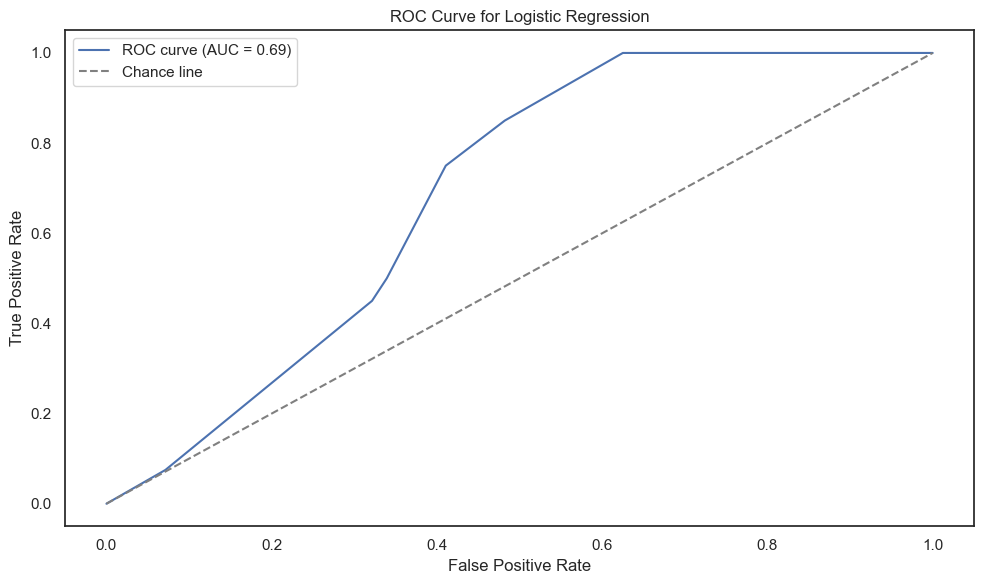

In [90]:
log_reg1_roc_auc_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.lineplot(
    x=log_reg1_fpr,
    y=log_reg1_tpr,
    label=f'ROC curve (AUC = {log_reg1_roc_auc:.2f})',
    ax=ax,
    errorbar=None
)
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance line')
ax.set_title('ROC Curve for Logistic Regression')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

log_reg1_roc_auc_plot.tight_layout()
log_reg1_roc_auc_plot.savefig(f'{project_data_exports_path}/log_reg1_roc_auc_plot.png', dpi=300, bbox_inches='tight')

## Decision Tree

In [91]:
tree_clf1_pipe = Pipeline([
    ('preprocessor', preprocessor_tree1),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

tree_clf1_pipe.get_params()

tree_clf1_params = [{'classifier__max_depth': [2, 3, 4],
                'classifier__min_samples_split': [2, 3, 4],
                'classifier__random_state': [0]}]

tree_clf1_gs = GridSearchCV(estimator=tree_clf1_pipe,
                      param_grid=tree_clf1_params,
                      cv=5,
                      scoring='roc_auc',
                      verbose=1)

tree_clf1_scores = cross_val_score(tree_clf1_gs,
                             X1_train,
                             y1_train,
                             scoring='roc_auc')

tree_clf1_model = tree_clf1_gs.fit(X1_train, y1_train)
tree_clf1_best_params = tree_clf1_gs.best_params_
tree_clf1_best_pipe = tree_clf1_gs.best_estimator_


tree_clf1_preds = tree_clf1_model.predict(X1_test)
tree_clf1_probs = tree_clf1_model.predict_proba(X1_test)[:, 1]

tree_clf1_fpr, tree_clf1_tpr, tree_clf1_thresholds = roc_curve(y1_test, tree_clf1_probs)
tree_clf1_precision, tree_clf1_recall, tree_clf1_pr_thresholds = precision_recall_curve(y1_test, tree_clf1_probs)
tree_clf1_roc_auc = roc_auc_score(y1_test, tree_clf1_probs)
print('ROC-AUC Score:', tree_clf1_roc_auc)
print('Accuracy', accuracy_score(y1_test, tree_clf1_preds))

tree_clf1_conf_mat = confusion_matrix(y1_test, tree_clf1_preds, labels=tree_clf1_best_pipe.named_steps['classifier'].classes_)
tree_clf1_conf_mat = pd.DataFrame(tree_clf1_conf_mat, index = ['Actual ' + str(cls) for cls in tree_clf1_best_pipe.named_steps['classifier'].classes_], columns=['Predicted ' + str(cls) for cls in tree_clf1_best_pipe.named_steps['classifier'].classes_])
tree_clf1_conf_mat.to_csv(f'{project_data_exports_path}/tree_clf1_confusion_matrix.csv')
tree_clf1_conf_mat

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
ROC-AUC Score: 0.7339285714285714
Accuracy 0.7763157894736842


,Predicted 0,Predicted 1
Actual 0,55,1
Actual 1,16,4


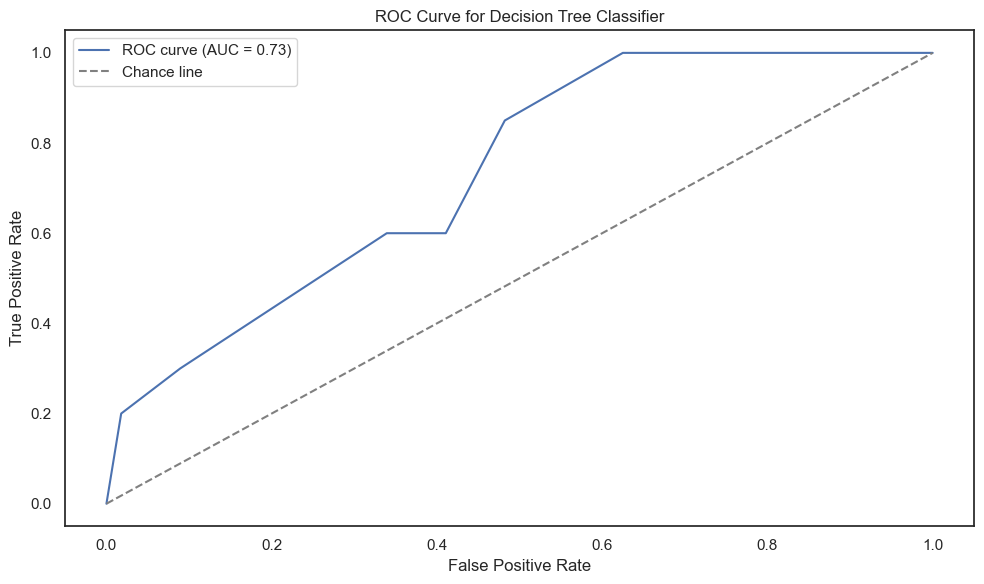

In [92]:
tree_clf1_roc_auc_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.lineplot(
    x=tree_clf1_fpr,
    y=tree_clf1_tpr,
    label=f'ROC curve (AUC = {tree_clf1_roc_auc:.2f})',
    ax=ax
)
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance line')
ax.set_title('ROC Curve for Decision Tree Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

tree_clf1_roc_auc_plot.tight_layout()
tree_clf1_roc_auc_plot.savefig(f'{project_data_exports_path}/tree_clf1_roc_auc_plot.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Best Decision Tree Classifier from Grid Search')

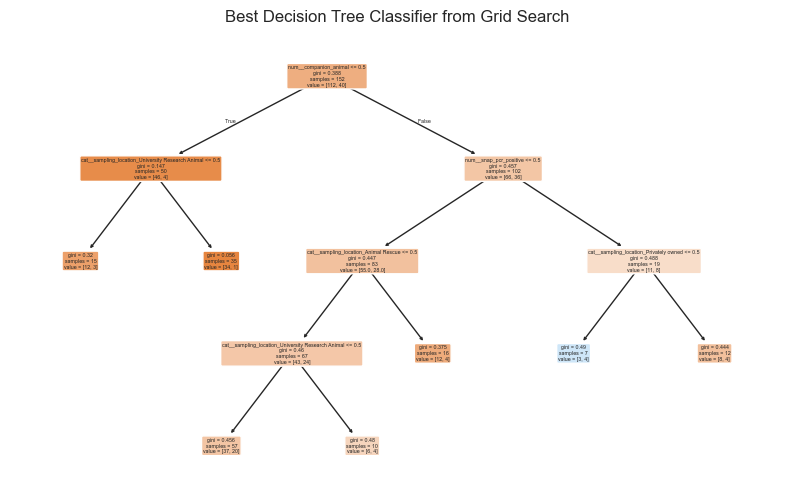

In [93]:
tree_clf1_feature_names = tree_clf1_best_pipe.named_steps['preprocessor'].get_feature_names_out()

tree_clf1_tree_plot, ax = plt.subplots(1, 1, figsize=(10,6))

plot_tree(tree_clf1_best_pipe.named_steps['classifier'], filled=True, feature_names=tree_clf1_feature_names, rounded=True, ax=ax)

ax.set_title('Best Decision Tree Classifier from Grid Search')

## Random Forest

In [94]:
rf_clf1_pipe = Pipeline([
    ('preprocessor', preprocessor_tree1),
    ('classifier', RandomForestClassifier(random_state=0))
])

rf_clf1_pipe.get_params()

rf_clf1_params = [{'classifier__n_estimators': [500],
              'classifier__max_depth': [1, 2, 3, 4],
              'classifier__random_state': [0]}]

rf_clf1_gs = GridSearchCV(estimator=rf_clf1_pipe,
                      param_grid=rf_clf1_params,
                      cv=5,
                      scoring='roc_auc',
                      verbose=1)

rf_clf1_scores = cross_val_score(rf_clf1_gs,
                             X1_train,
                             y1_train,
                             scoring='roc_auc')

rf_clf1_model = rf_clf1_gs.fit(X1_train, y1_train)
rf_clf1_best_params = rf_clf1_gs.best_params_
rf_clf1_best_pipe = rf_clf1_gs.best_estimator_


rf_clf1_preds = rf_clf1_model.predict(X1_test)
rf_clf1_probs = rf_clf1_model.predict_proba(X1_test)[:, 1]

rf_clf1_fpr, rf_clf1_tpr, rf_clf1_thresholds = roc_curve(y1_test, rf_clf1_probs)
rf_clf1_precision, rf_clf1_recall, rf_clf1_pr_thresholds = precision_recall_curve(y1_test, rf_clf1_probs)
rf_clf1_roc_auc = roc_auc_score(y1_test, rf_clf1_probs)
print('ROC-AUC Score:', rf_clf1_roc_auc)
print('Accuracy', accuracy_score(y1_test, rf_clf1_preds))

rf_clf1_conf_mat = confusion_matrix(y1_test, rf_clf1_preds, labels=rf_clf1_best_pipe.named_steps['classifier'].classes_)
rf_clf1_conf_mat = pd.DataFrame(rf_clf1_conf_mat, index = ['Actual ' + str(cls) for cls in rf_clf1_best_pipe.named_steps['classifier'].classes_], columns=['Predicted ' + str(cls) for cls in rf_clf1_best_pipe.named_steps['classifier'].classes_])
rf_clf1_conf_mat.to_csv(f'{project_data_exports_path}/rf_clf1_confusion_matrix.csv')
rf_clf1_conf_mat

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
ROC-AUC Score: 0.735267857142857
Accuracy 0.7763157894736842


,Predicted 0,Predicted 1
Actual 0,56,0
Actual 1,17,3


                                             Feature  Importance
1                              num__companion_animal    0.471744
0                             num__snap_pcr_positive    0.169605
4  cat__sampling_location_University Research Animal    0.166584
3             cat__sampling_location_Privately owned    0.122396
2               cat__sampling_location_Animal Rescue    0.069671


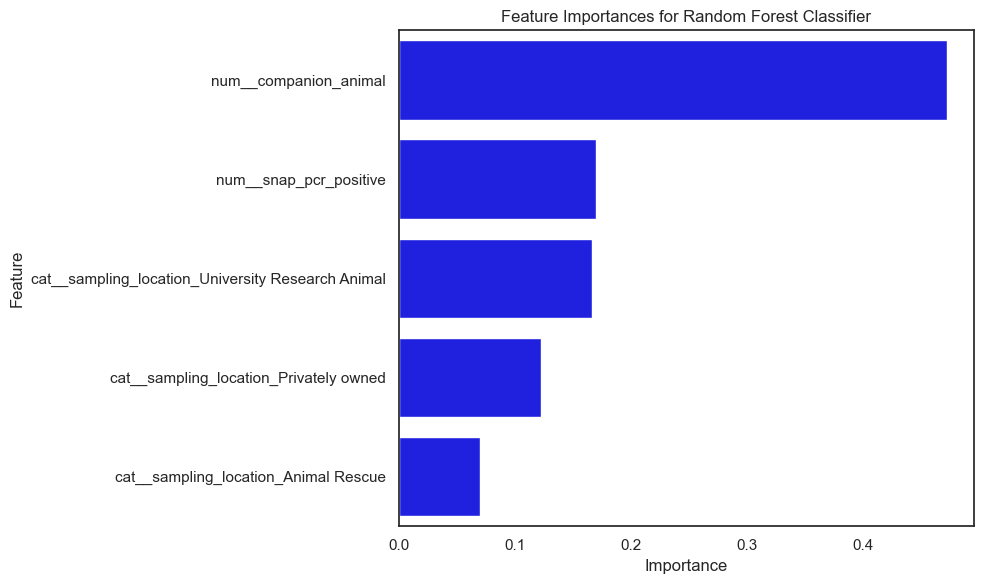

In [95]:
rf_clf1_feature_importances = rf_clf1_best_pipe.named_steps['classifier'].feature_importances_

rf_clf1_transformed_feature_names = rf_clf1_best_pipe.named_steps['preprocessor'].get_feature_names_out()

rf1_features_df = pd.DataFrame({
    'Feature': rf_clf1_transformed_feature_names,
    'Importance': rf_clf1_feature_importances
}).sort_values(by=['Importance'], ascending=False).head(10)
rf1_features_df.to_csv(f'{project_data_exports_path}/ref1_features_df.csv')

print(rf1_features_df)

rf_clf1_feature_importances_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.barplot(
    data=rf1_features_df,
    x='Importance',
    y='Feature',
    color='blue',
    ax=ax
)
ax.set_title('Feature Importances for Random Forest Classifier')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

rf_clf1_feature_importances_plot.tight_layout()
rf_clf1_feature_importances_plot.savefig(f'{project_data_exports_path}/rf_clf1_feature_importances_plot.png', dpi=300)

In [96]:
rf_clf1_feature_importances_df = pd.DataFrame({
    'Feature': rf_clf1_transformed_feature_names,
    'Importance': rf_clf1_feature_importances
}).sort_values(by=['Importance'], ascending=False)
rf_clf1_feature_importances_df.to_csv(f'{project_data_exports_path}/rf_clf1_feature_importances_df.csv')
rf_clf1_feature_importances_df

,Feature,Importance
1,num__companion_animal,0.471744
0,num__snap_pcr_positive,0.169605
4,cat__sampling_location_University Research Animal,0.166584
3,cat__sampling_location_Privately owned,0.122396
2,cat__sampling_location_Animal Rescue,0.069671


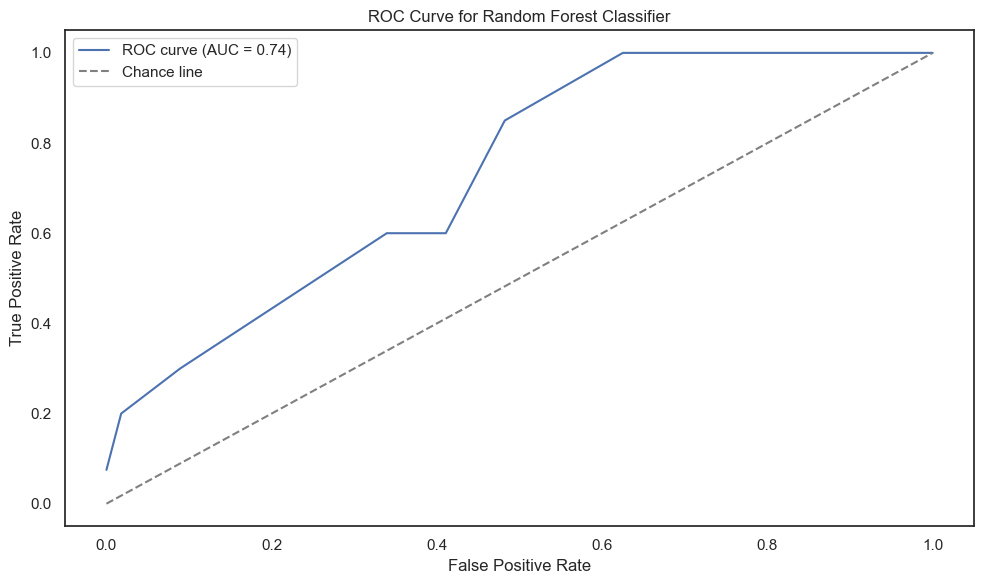

In [97]:
rf_clf1_roc_auc_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.lineplot(
    x=rf_clf1_fpr,
    y=rf_clf1_tpr,
    label=f'ROC curve (AUC = {rf_clf1_roc_auc:.2f})',
    ax=ax,
    errorbar=None
)
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance line')
ax.set_title('ROC Curve for Random Forest Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

rf_clf1_roc_auc_plot.tight_layout()
rf_clf1_roc_auc_plot.savefig(f'{project_data_exports_path}/rf_clf1_roc_auc_plot.png', dpi=300, bbox_inches='tight')

# Predict snap_pcr_positive by ectoparasite, companion_animal, and sampling_location

In [98]:
y2 = df.loc[:, ['snap_pcr_positive']]
y2['snap_pcr_positive'] = y2['snap_pcr_positive'].astype(int)
X2 = df.loc[:, ['ectoparasite', 'companion_animal', 'sampling_location']]

In [99]:
print(y2.isna().sum())
X2.isna().sum()

snap_pcr_positive    0
dtype: int64


ectoparasite         0
companion_animal     0
sampling_location    0
dtype: int64

In [100]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=0, stratify=y2)

In [101]:
numeric_features2 = make_column_selector(dtype_include=np.number)
numeric_features2 = numeric_features2(X2_train)
print(numeric_features2)

numeric_transformer_non_tree2 = Pipeline(steps=[
    ('std_scaler', StandardScaler())])

numeric_transformer_tree2 = 'passthrough'

categorical_features2 = make_column_selector(dtype_include=[object, 'category'])
categorical_features2 = categorical_features2(X2_train)
print(categorical_features2)

categorical_transformer2 = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_non_tree2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_non_tree2, numeric_features2),
        ('cat', categorical_transformer2, categorical_features2)
    ]
)

preprocessor_tree2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_tree2, numeric_features2),
        ('cat', categorical_transformer2, categorical_features2)
    ]
)

['ectoparasite', 'companion_animal']
['sampling_location']


## Logisitc Regression

In [186]:
log_reg2_pipe = Pipeline([
    ('preprocessor', preprocessor_non_tree2),
    ('classifier', LogisticRegression())
])

log_reg2_cv_scores = cross_val_score(log_reg2_pipe, X2_train, y2_train, cv=KFold(n_splits=10, shuffle=True, random_state=0))
print('Cross-validation Scores:', log_reg2_cv_scores)
print('CV Mean Accuracy:', log_reg2_cv_scores.mean())

log_reg2_model = log_reg2_pipe.fit(X2_train, y2_train)

log_reg2_fitted_model = log_reg2_model.named_steps['classifier']
log_reg2_feature_names = log_reg2_model.named_steps['preprocessor'].get_feature_names_out()

log_reg2_coefficients = log_reg2_fitted_model.coef_[0]
log_reg2_intercept = log_reg2_fitted_model.intercept_[0]

log_reg2_X_design = log_reg2_model.named_steps['preprocessor'].transform(X2_train)
log_reg2_X_design = np.hstack([np.ones((log_reg2_X_design.shape[0], 1)), log_reg2_X_design])
log_reg2_cov_matrix = np.linalg.inv(np.dot(log_reg2_X_design.T, log_reg2_X_design))
log_reg2_standard_errors = np.sqrt(np.diag(log_reg2_cov_matrix))

log_reg2_z_scores = log_reg2_coefficients / log_reg2_standard_errors[1:]

log_reg2_p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in log_reg2_z_scores]

log_reg2_coefficient_names = ['Intercept'] + list(log_reg2_feature_names)
log_reg2_coefficient_values = [log_reg2_intercept] + list(log_reg2_coefficients)
log_reg2_p_values_with_intercept = [None] + log_reg2_p_values

log_reg2_coefficient_p_value_df = pd.DataFrame({
    'Coefficient Name': log_reg2_coefficient_names,
    'Coefficient Value': log_reg2_coefficient_values,
    'P-Value': log_reg2_p_values_with_intercept
})
log_reg2_coefficient_p_value_df.to_csv(f'{project_data_exports_path}/log_reg2_coefficient_p_value.csv')
print(log_reg2_coefficient_p_value_df)

log_reg2_preds = log_reg2_model.predict(X2_test)
log_reg2_probs = log_reg2_model.predict_proba(X2_test)[:, 1]

log_reg2_fpr, log_reg2_tpr, log_reg2_thresholds = roc_curve(y2_test, log_reg2_probs)
log_reg2_precision, log_reg2_recall, log_reg2_pr_thresholds = precision_recall_curve(y2_test, log_reg2_probs)
log_reg2_roc_auc = roc_auc_score(y2_test, log_reg2_probs)
print('ROC-AUC Score:', log_reg2_roc_auc)
print('Accuracy', accuracy_score(y2_test, log_reg2_preds))

log_reg2_conf_mat = confusion_matrix(y2_test, log_reg2_preds, labels=log_reg2_pipe.classes_)
log_reg2_conf_mat = pd.DataFrame(log_reg2_conf_mat, index = ['Actual ' + str(cls) for cls in log_reg2_pipe.classes_], columns=['Predicted ' + str(cls) for cls in log_reg2_pipe.classes_])
log_reg2_conf_mat.to_csv(f'{project_data_exports_path}/log_reg2_conf_mat.csv')
log_reg2_conf_mat

Cross-validation Scores: [0.875      1.         0.93333333 0.8        0.8        0.6
 0.93333333 0.93333333 0.86666667 1.        ]
CV Mean Accuracy: 0.8741666666666668
                                    Coefficient Name  Coefficient Value  \
0                                          Intercept          -2.446350   
1                                  num__ectoparasite           0.205731   
2                              num__companion_animal           1.299696   
3               cat__sampling_location_Animal Rescue           0.506641   
4             cat__sampling_location_Privately owned          -0.268172   
5  cat__sampling_location_University Research Animal          -0.240883   

    P-Value  
0       NaN  
1  0.016583  
2  0.000000  
3  1.000000  
4  1.000000  
5  1.000000  
ROC-AUC Score: 0.7014925373134329
Accuracy 0.881578947368421


/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y 

,Predicted 0,Predicted 1
Actual 0,67,0
Actual 1,9,0


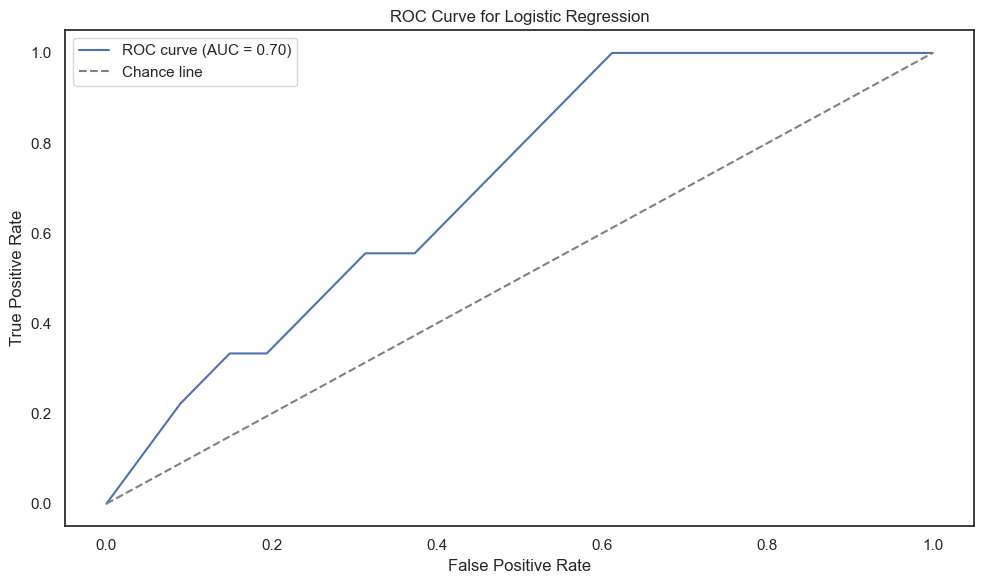

In [103]:
log_reg2_roc_auc_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.lineplot(
    x=log_reg2_fpr,
    y=log_reg2_tpr,
    label=f'ROC curve (AUC = {log_reg2_roc_auc:.2f})',
    ax=ax,
    errorbar=None
)
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance line')
ax.set_title('ROC Curve for Logistic Regression')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

log_reg2_roc_auc_plot.tight_layout()
log_reg2_roc_auc_plot.savefig(f'{project_data_exports_path}/log_reg2_roc_auc_plot.png', dpi=300, bbox_inches='tight')

## Decision Tree

In [104]:
tree_clf2_pipe = Pipeline([
    ('preprocessor', preprocessor_tree2),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

tree_clf2_pipe.get_params()

tree_clf2_params = [{'classifier__max_depth': [2, 3, 4],
                'classifier__min_samples_split': [2, 3, 4],
                'classifier__random_state': [0]}]

tree_clf2_gs = GridSearchCV(estimator=tree_clf2_pipe,
                      param_grid=tree_clf2_params,
                      cv=5,
                      scoring='roc_auc',
                      verbose=1)

tree_clf2_scores = cross_val_score(tree_clf2_gs,
                             X2_train,
                             y2_train,
                             scoring='roc_auc')

tree_clf2_model = tree_clf2_gs.fit(X2_train, y2_train)
tree_clf2_best_params = tree_clf2_gs.best_params_
tree_clf2_best_pipe = tree_clf2_gs.best_estimator_


tree_clf2_preds = tree_clf2_model.predict(X2_test)
tree_clf2_probs = tree_clf2_model.predict_proba(X2_test)[:, 1]

tree_clf2_fpr, tree_clf2_tpr, tree_clf2_thresholds = roc_curve(y2_test, tree_clf2_probs)
tree_clf2_precision, tree_clf2_recall, tree_clf2_pr_thresholds = precision_recall_curve(y2_test, tree_clf2_probs)
tree_clf2_roc_auc = roc_auc_score(y2_test, tree_clf2_probs)
print('ROC-AUC Score:', tree_clf2_roc_auc)
print('Accuracy', accuracy_score(y2_test, tree_clf2_preds))

tree_clf2_conf_mat = confusion_matrix(y2_test, tree_clf2_preds, labels=tree_clf2_best_pipe.named_steps['classifier'].classes_)
tree_clf2_conf_mat = pd.DataFrame(tree_clf2_conf_mat, index = ['Actual ' + str(cls) for cls in tree_clf2_best_pipe.named_steps['classifier'].classes_], columns=['Predicted ' + str(cls) for cls in tree_clf2_best_pipe.named_steps['classifier'].classes_])
tree_clf2_conf_mat.to_csv(f'{project_data_exports_path}/tree_clf2_conf_mat.csv')
tree_clf2_conf_mat

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
ROC-AUC Score: 0.7213930348258706
Accuracy 0.881578947368421


,Predicted 0,Predicted 1
Actual 0,67,0
Actual 1,9,0


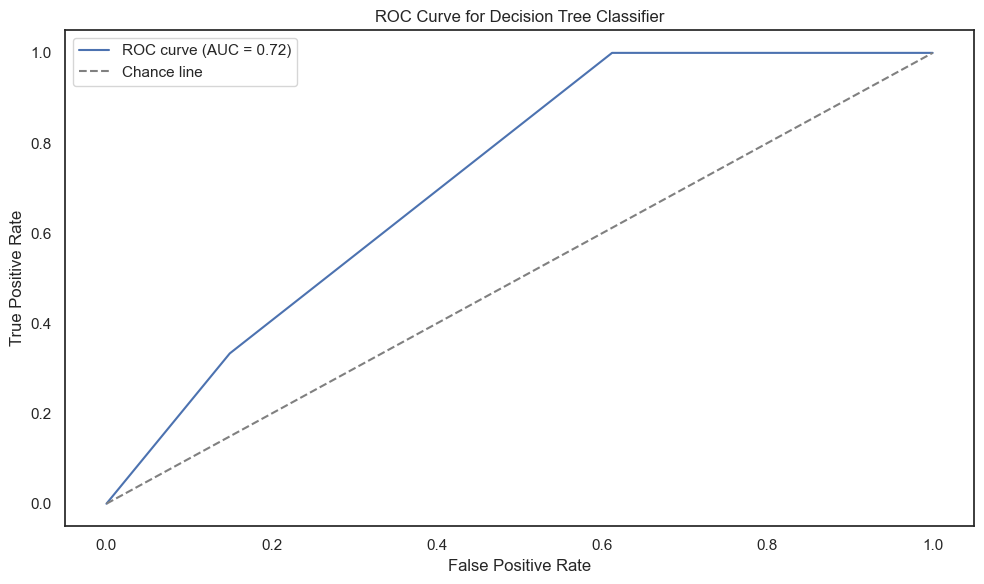

In [105]:
tree_clf2_roc_auc_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.lineplot(
    x=tree_clf2_fpr,
    y=tree_clf2_tpr,
    label=f'ROC curve (AUC = {tree_clf2_roc_auc:.2f})',
    ax=ax
)
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance line')
ax.set_title('ROC Curve for Decision Tree Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

tree_clf2_roc_auc_plot.tight_layout()
tree_clf2_roc_auc_plot.savefig(f'{project_data_exports_path}/tree_clf2_roc_auc_plot.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Best Decision Tree Classifier from Grid Search')

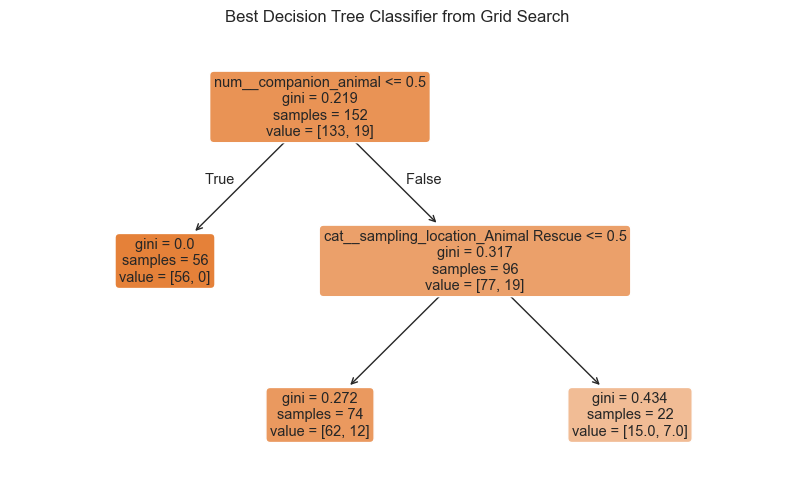

In [106]:
tree_clf2_feature_names = tree_clf2_best_pipe.named_steps['preprocessor'].get_feature_names_out()

tree_clf2_tree_plot, ax = plt.subplots(1, 1, figsize=(10,6))

plot_tree(tree_clf2_best_pipe.named_steps['classifier'], filled=True, feature_names=tree_clf2_feature_names, rounded=True, ax=ax)

ax.set_title('Best Decision Tree Classifier from Grid Search')

## Random Forest

In [107]:
rf_clf2_pipe = Pipeline([
    ('preprocessor', preprocessor_tree2),
    ('classifier', RandomForestClassifier(random_state=0))
])

rf_clf2_pipe.get_params()

rf_clf2_params = [{'classifier__n_estimators': [500],
              'classifier__max_depth': [1, 2, 3, 4],
              'classifier__random_state': [0]}]

rf_clf2_gs = GridSearchCV(estimator=rf_clf2_pipe,
                      param_grid=rf_clf2_params,
                      cv=5,
                      scoring='roc_auc',
                      verbose=1)

rf_clf2_scores = cross_val_score(rf_clf2_gs,
                             X2_train,
                             y2_train,
                             scoring='roc_auc')

rf_clf2_model = rf_clf2_gs.fit(X2_train, y2_train)
rf_clf2_best_params = rf_clf2_gs.best_params_
rf_clf2_best_pipe = rf_clf2_gs.best_estimator_


rf_clf2_preds = rf_clf2_model.predict(X2_test)
rf_clf2_probs = rf_clf2_model.predict_proba(X2_test)[:, 1]

rf_clf2_fpr, rf_clf2_tpr, rf_clf2_thresholds = roc_curve(y2_test, rf_clf2_probs)
rf_clf2_precision, rf_clf2_recall, rf_clf2_pr_thresholds = precision_recall_curve(y2_test, rf_clf2_probs)
rf_clf2_roc_auc = roc_auc_score(y2_test, rf_clf2_probs)
print('ROC-AUC Score:', rf_clf2_roc_auc)
print('Accuracy', accuracy_score(y2_test, rf_clf2_preds))

rf_clf2_conf_mat = confusion_matrix(y2_test, rf_clf2_preds, labels=rf_clf2_best_pipe.named_steps['classifier'].classes_)
rf_clf2_conf_mat = pd.DataFrame(rf_clf2_conf_mat, index = ['Actual ' + str(cls) for cls in rf_clf2_best_pipe.named_steps['classifier'].classes_], columns=['Predicted ' + str(cls) for cls in rf_clf2_best_pipe.named_steps['classifier'].classes_])
rf_clf2_conf_mat.to_csv(f'{project_data_exports_path}/rf_clf2_conf_mat.csv')
rf_clf2_conf_mat

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please cha

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please cha

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please cha

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please cha

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please cha

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/chrisizenour/opt/anaconda3/envs/katie_dissertation/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please cha

ROC-AUC Score: 0.703150912106136
Accuracy 0.8289473684210527


,Predicted 0,Predicted 1
Actual 0,61,6
Actual 1,7,2


                                             Feature  Importance
0                                  num__ectoparasite    0.316993
1                              num__companion_animal    0.287494
2               cat__sampling_location_Animal Rescue    0.217329
3             cat__sampling_location_Privately owned    0.103304
4  cat__sampling_location_University Research Animal    0.074880


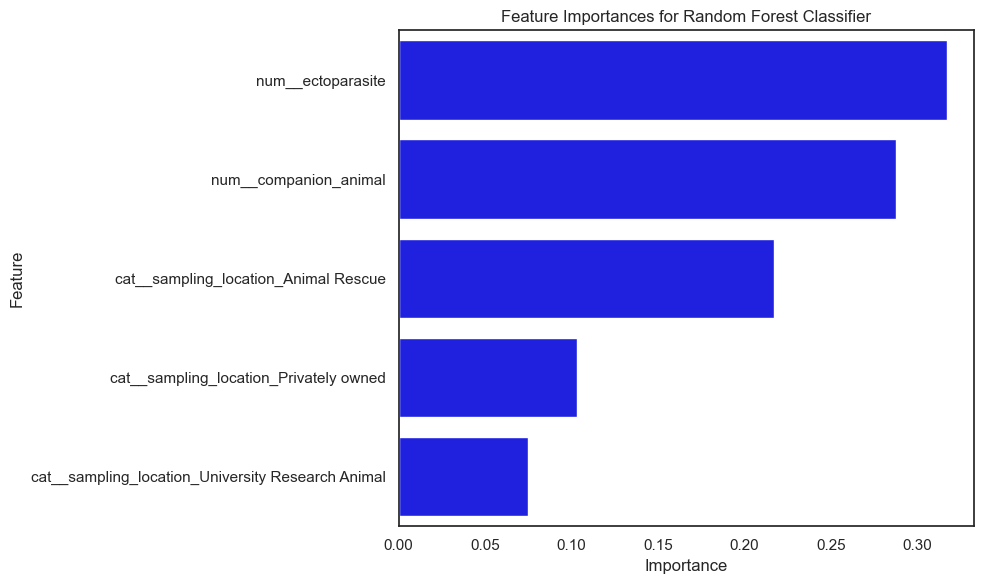

In [108]:
rf_clf2_feature_importances = rf_clf2_best_pipe.named_steps['classifier'].feature_importances_

rf_clf2_transformed_feature_names = rf_clf2_best_pipe.named_steps['preprocessor'].get_feature_names_out()

rf2_features_df = pd.DataFrame({
    'Feature': rf_clf2_transformed_feature_names,
    'Importance': rf_clf2_feature_importances
}).sort_values(by=['Importance'], ascending=False).head(10)
rf2_features_df.to_csv(f'{project_data_exports_path}/rf2_features_df.csv')

print(rf2_features_df)

rf_clf2_feature_importances_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.barplot(
    data=rf2_features_df,
    x='Importance',
    y='Feature',
    color='blue',
    ax=ax
)
ax.set_title('Feature Importances for Random Forest Classifier')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

rf_clf2_feature_importances_plot.tight_layout()
rf_clf2_feature_importances_plot.savefig(f'{project_data_exports_path}/rf_clf2_feature_importances_plot.png', dpi=300)

In [109]:
rf_clf2_featrue_importances_df = pd.DataFrame({
    'Feature': rf_clf2_transformed_feature_names,
    'Importance': rf_clf2_feature_importances
}).sort_values(by=['Importance'], ascending=False)
rf_clf2_featrue_importances_df.to_csv(f'{project_data_exports_path}/rf_clf2_featrue_importances_df.csv')

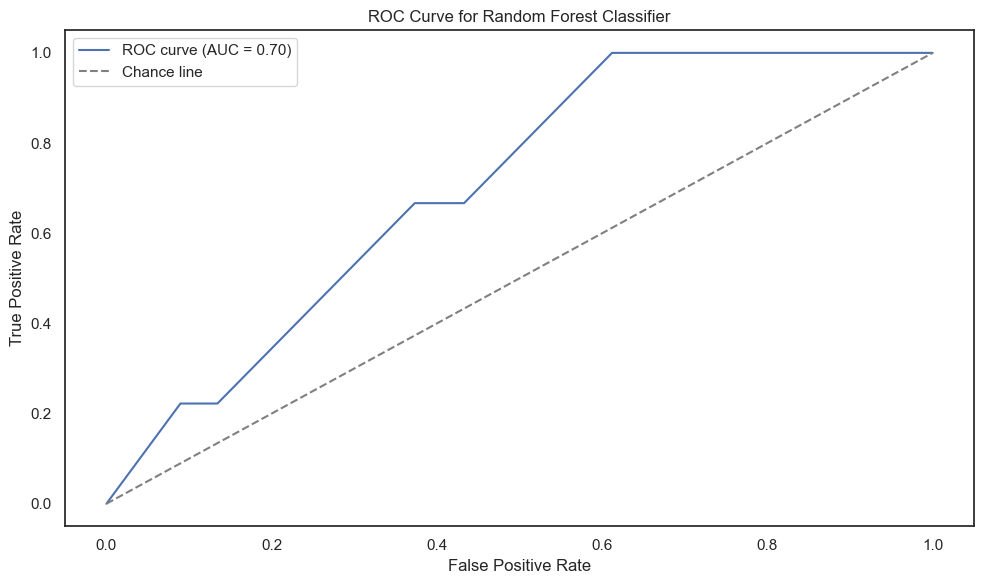

In [110]:
rf_clf2_roc_auc_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.lineplot(
    x=rf_clf2_fpr,
    y=rf_clf2_tpr,
    label=f'ROC curve (AUC = {rf_clf2_roc_auc:.2f})',
    ax=ax,
    errorbar=None
)
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance line')
ax.set_title('ROC Curve for Random Forest Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

rf_clf2_roc_auc_plot.tight_layout()
rf_clf2_roc_auc_plot.savefig(f'{project_data_exports_path}/rf_clf2_roc_auc_plot.png', dpi=300, bbox_inches='tight')